Funzioni di Gestione files

In [3]:
import pickle
import pandas as pd # type: ignore
import numpy as np # type: ignore
from conllu import parse, TokenList # type: ignore

#deserialize data from a file
def load_data(file_name,language):
    path="../data/"+language+"/"+file_name
    try: 
        file = open(path, 'rb') 
        data = pickle.load(file) 
        return data
    except: 
        print("Error in reading data")


# function to read data from file
def read_dataset(file_name,language):
    path="../data/"+language+"/dataset/"+file_name+".conllu"
    data = pd.read_csv (path, sep = '\t',quoting=3, names=["POSITION","WORD","TAG"])
    return data



# Funzione per salvare il DataFrame in un file CoNLL-U
def save_to_conllu(dataframe,file_name,language):
    # Creazione della lista di token da DataFrame
    path="../data/"+language+"/tagging/"+file_name
    tokens = []
    for _, row in dataframe.iterrows():
        token = {
            "id": row['POSITION'],
            "form": row['WORD'],
            "misc":  row['TAG']
        }
        tokens.append(token)
    
    # Creazione dell'oggetto TokenList
    token_list = TokenList(tokens)
    
    # Scrittura del TokenList nel file CoNLL-U
    with open(path, "w", encoding="utf-8") as f:
        f.write(token_list.serialize())
    print("DataFrame salvato in formato CoNLL-U:", path)





Funzioni di manipolazione e creazione del golden system

In [4]:
def extract_sentences_from_dataframe(df):
    sentences = []
    current_sentence = []

    for index, row in df.iterrows():
        position = row['POSITION']
        if position == 0 and current_sentence:  # Se è il primo elemento di una nuova frase e c'è una frase in corso
            sentences.append(' '.join([str(word) for word in current_sentence]))  # Aggiungi la frase corrente alla lista delle frasi
            current_sentence = []  # Inizia una nuova frase
        
        current_sentence.append(row['WORD'])  # Aggiungi la parola corrente alla frase in corso

    # Aggiungi l'ultima frase alla lista delle frasi se presente
    if current_sentence:
        sentences.append(' '.join([word for word in current_sentence]))

    return sentences


Viterbi

In [39]:
#implementazione dell'algoritmo di viterbi con la prevenzione dell'underflow tramite logaritmo e probabilità iniziale omogenea

def viterbi(emission_df, transition_df):
    # Numero di stati
    num_states = len(transition_df)

    # Inizializzazione della matrice di probabilità
    dp = pd.DataFrame(index=range(num_states), columns=range(len(emission_df.columns)))
    pi = 1 / num_states #Probabilità iniziale equiprobabile
    dp.iloc[:, 0] = np.log(pi) + np.log(emission_df.iloc[:, 0] + 1e-10)

    # Inizializzazione del percorso ottimale
    path = {state: [state] for state in range(num_states)}

    # Ciclo attraverso le osservazioni
    for t in range(1, len(emission_df.columns)):
        new_path = {}

        # Ciclo attraverso i possibili stati
        for state in range(num_states):
            # Calcolo della probabilità massima
            max_prob = float('-inf')
            max_state = None
            for prev_state in range(num_states):
                prob = dp.iloc[prev_state, t-1] + np.log(transition_df.iloc[state, prev_state] + 1e-10) + np.log(emission_df.iloc[state, t] + 1e-10)
                if prob > max_prob:
                    max_prob = prob
                    max_state = prev_state
            
            dp.iloc[state, t] = max_prob

            # Aggiornamento del percorso ottimale
            new_path[state] = path[max_state] + [state]

        path = new_path

    # Ritorno del percorso ottimale
    max_prob = dp.iloc[:, len(emission_df.columns)-1].max()
    max_path = path[dp.iloc[:, len(emission_df.columns)-1].idxmax()]

    # Stampa a schermo il percorso di Viterbi
    # print('Il percorso di Viterbi è:', ' -> '.join(emission_df.index[max_path]))

    return pd.DataFrame({'POSITION': range(len(max_path)), 'WORD': emission_df.columns, 'TAG': [emission_df.index[state] for state in max_path]})


Creazione del sub-dataset di probabilità di emissione per le parole di una frase.

Applicazione di diverse tecniche di smoothing per gestire le parole sconosciute:

1 - Sempre O: P(unk|O) = 1

2 - Sempre O o MISC: P(unk|O)=P(unk|B-MISC)=0.5

3 - Uniforme: P(unk|tag) = 1/#(NER_TAGs)

4 - Statistica TAG sul val set: parole che compaiono 1 sola volta  -> unknown_prob calcolata nel file learning 


In [40]:
#prende in input una frase, le probabilità di emisione e transizione apprese 
#restituisce le coppie parola-NER_TAG assegnate utilizzano l'algoritmo di Viterbi e applicando la tecnica di smoothing specificata
def viterbi_tagger(sentences, emission_prob, transition_prob, unkown_prob, smoothing_type):
    #inizializzazione
    tags=transition_prob.keys()
    transition_df = pd.DataFrame.from_dict(transition_prob)
    all_sentences_tag = pd.DataFrame()
    
    for sentence in sentences:
        words = sentence.split()
        emission_sentence_df = pd.DataFrame(columns=words,index=tags)
     
        for word in words:
            if word in emission_prob:
                emission_sentence_df[word] = pd.Series(emission_prob[word]).values
            else: #applicazione dello smoothing
                if (smoothing_type==1): emission_sentence_df[word] =  {tag: 1 if tag == "O" else 0 for tag in tags}
                elif (smoothing_type==2): emission_sentence_df[word] =  {tag: 0.5 if tag == "B-MISC" or tag == "O" else 0.0001 for tag in tags}
                elif (smoothing_type==3): emission_sentence_df[word] =  {tag: 1/len(tags) for tag in tags}
                elif (smoothing_type==4): emission_sentence_df[word] =  unkown_prob

        sent_tag=viterbi(emission_sentence_df, transition_df)
        all_sentences_tag=pd.concat([all_sentences_tag, sent_tag], axis=0)
    return all_sentences_tag


In [41]:
sentence = "The PAROLASCONOSCIUTA tour would cover the United States and the UK and Ireland throughout 2019 ."
sentence2= "I love to play League of Legends from Riot Games on my computer"
emission_prob=load_data("emission_prob","en")
transition_prob=load_data("transition_prob","en")
unkown_prob=load_data("unknown_prob","en")
viterbi_tagger([sentence,sentence2], emission_prob, transition_prob, unkown_prob,4)

,POSITION,WORD,TAG
0,0,The,O
1,1,PAROLASCONOSCIUTA,O
2,2,tour,O
3,3,would,O
4,4,cover,O
5,5,the,O
6,6,United,B-LOC
7,7,States,I-LOC
8,8,and,O
9,9,the,O


NAIVE TAGGER

In [8]:
#Naive tagger --> utilizza la probabilità di emissione più alta, se parola sconosciuta --> B-MISC

def naive_tagger(sentences, emission_prob):
 
 tags = []
 final_df = pd.DataFrame()

 for sentence in sentences:
    words = sentence.split()
    tags = []
    for word in words:
        if word in emission_prob:
            tags.append(max(emission_prob[word], key=emission_prob[word].get))
        else:
            tags.append("B-MISC")
    
    # Creazione del DataFrame
    df = pd.DataFrame({'WORD': words, 'TAG': tags})
    df['POSITION'] = df.index  # Aggiunge la colonna POSITION
    df = df[['POSITION', 'WORD', 'TAG']]  # Riordina le colonne

    final_df=pd.concat([final_df, df], axis=0)  
    
 return final_df



Esempio di Decoding Completo

In [45]:
for language in ["en","it","es"]:

 print( "inizio lingua: "+language) 
 emission_prob=load_data("emission_prob",language)
 transition_prob=load_data("transition_prob",language)
 unkown_prob=load_data("unknown_prob",language)

 #carico il file di test, estraggo la sentence e pongo il test set df come golden_df
 golden_tot = read_dataset("test",language)
 golden_df = golden_tot.head(10000)
 sentence = extract_sentences_from_dataframe(golden_df)
 #print(sentence)
 vit_df=viterbi_tagger(sentence,emission_prob,transition_prob,unkown_prob,4)
 naive_df=naive_tagger(sentence, emission_prob)

 save_to_conllu(golden_df, "golden_tag.conllu", language)
 save_to_conllu(vit_df, "viterbi_tag.conllu", language)
 save_to_conllu(naive_df, "naive_tag.conllu", language)
 print( "fine lingua: "+language)

inizio lingua: en
DataFrame salvato in formato CoNLL-U: ../data/en/tagging/golden_tag.conllu
DataFrame salvato in formato CoNLL-U: ../data/en/tagging/viterbi_tag.conllu
DataFrame salvato in formato CoNLL-U: ../data/en/tagging/naive_tag.conllu
fine lingua: en
inizio lingua: it
DataFrame salvato in formato CoNLL-U: ../data/it/tagging/golden_tag.conllu
DataFrame salvato in formato CoNLL-U: ../data/it/tagging/viterbi_tag.conllu
DataFrame salvato in formato CoNLL-U: ../data/it/tagging/naive_tag.conllu
fine lingua: it
inizio lingua: es
DataFrame salvato in formato CoNLL-U: ../data/es/tagging/golden_tag.conllu
DataFrame salvato in formato CoNLL-U: ../data/es/tagging/viterbi_tag.conllu
DataFrame salvato in formato CoNLL-U: ../data/es/tagging/naive_tag.conllu
fine lingua: es


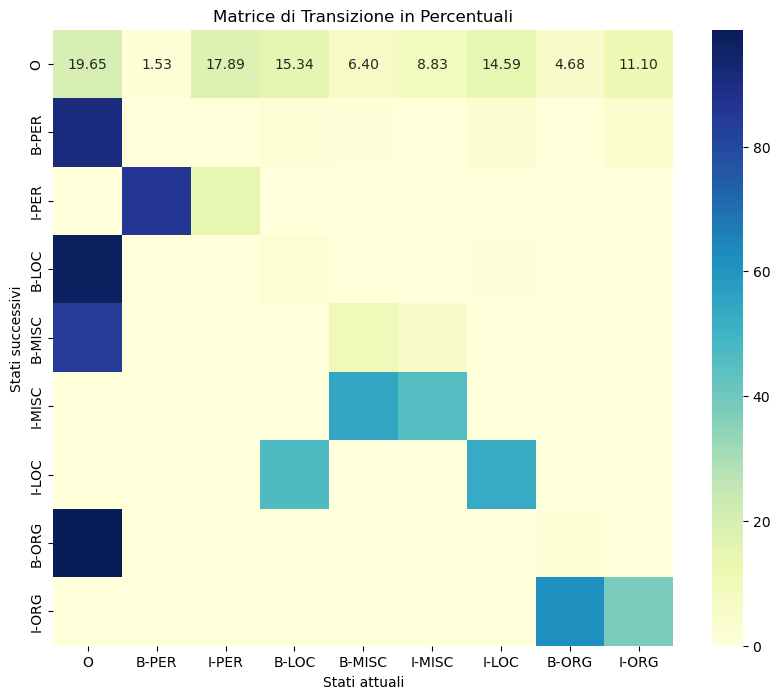

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def convert_to_percentage_and_plot(emission_prob, transition_prob):

    emission_df = pd.DataFrame(emission_prob,)
    transition_df = pd.DataFrame(transition_prob)
        # Conversione in percentuali
    def to_percentage(df):
        return df.div(df.sum(axis=1), axis=0) * 100

    emission_perc = to_percentage(emission_df)
    transition_perc = to_percentage(transition_df)

    # Plotting delle matrici
    def plot_heatmap(df, title):
        plt.figure(figsize=(10, 8))
        sns.heatmap(df, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
        plt.title(title)
        plt.xlabel('Stati attuali')
        plt.ylabel('Stati successivi')
        plt.show()

    # Plot delle matrici
    #plot_heatmap(emission_perc, "Matrice di Emissione in Percentuali")
    plot_heatmap(transition_perc, "Matrice di Transizione in Percentuali")

    return emission_perc, transition_perc


# Chiamata alla funzione
emission_perc, transition_perc = convert_to_percentage_and_plot(emission_prob, transition_prob)